In [15]:
from DataNamesReference import *
from LstmTraining import getNonEmptyLines
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.naive_bayes as sklNaiveBayes
import sklearn.metrics as metrics

import matplotlib.pyplot as plt


In [3]:
SOURCE_DATASET_PATH= datasetDirPath


In [4]:
employmentTypeOptionsFilePath = os.path.join(SOURCE_DATASET_PATH, EMPLOYMENT_TYPE_OPTIONS_FILE_NAME)
requiredExperienceOptionsFilePath = os.path.join(SOURCE_DATASET_PATH, REQUIRED_EXPERIENCE_OPTIONS_FILE_NAME)
requiredEducationOptionsFilePath = os.path.join(SOURCE_DATASET_PATH, REQUIRED_EDUCATION_OPTIONS_FILE_NAME)
industryOptionsFilePath = os.path.join(SOURCE_DATASET_PATH, INDUSTRY_OPTIONS_FILE_NAME)
functionOptionsFilePath = os.path.join(SOURCE_DATASET_PATH, FUNCTION_OPTIONS_FILE_NAME)


with open(employmentTypeOptionsFilePath) as employmentTypeOptionsFile:
    employmentTypeOptions = employmentTypeOptionsFile.read().splitlines()

with open(requiredExperienceOptionsFilePath) as requiredExperienceOptionsFile:
    requiredExperienceOptions = requiredExperienceOptionsFile.read().splitlines()

with open(requiredEducationOptionsFilePath) as requiredEducationOptionsFile:
    requiredEducationOptions = requiredEducationOptionsFile.read().splitlines()

with open(industryOptionsFilePath) as industryOptionsFile:
    industryOptions = industryOptionsFile.read().splitlines()

with open(functionOptionsFilePath) as functionOptionsFile:
    functionOptions = functionOptionsFile.read().splitlines()

In [5]:
def convertDfToStrings(dataDf):
    caseStrings = []

    for caseIndex, caseRow in dataDf.iterrows():
        currCaseString = ""
        if caseRow[TELECOMMUTING_LABEL]:
            currCaseString += "telecommmute "
        if caseRow[HAS_LOGO_LABEL]:
            currCaseString += "has_logo "
        if caseRow[HAS_QUESTIONS_LABEL]:
            currCaseString += "has_questions "

        employmentTypeInd = caseRow[EMPLOYMENT_TYPE_LABEL]
        currCaseString += employmentTypeOptions[employmentTypeInd] + " "

        requiredExperienceInd = caseRow[REQUIRED_EXPERIENCE_LABEL]
        currCaseString += requiredExperienceOptions[requiredExperienceInd] + " "

        requiredEducationInd = caseRow[REQUIRED_EDUCATION_LABEL]
        currCaseString += requiredEducationOptions[requiredEducationInd] + " "

        industryInd = caseRow[INDUSTRY_LABEL]
        currCaseString += industryOptions[industryInd] + " "

        functionInd = caseRow[FUNCTION_LABEL]
        currCaseString += functionOptions[functionInd] + " "

        currCaseString += caseRow[TITLE_LABEL] + " "
        currCaseString += caseRow[LOCATION_LABEL] + " "
        currCaseString += caseRow[DEPARTMENT_LABEL] + " "
        currCaseString += caseRow[COMPANY_PROFILE_LABEL] + " "
        currCaseString += caseRow[DESCRIPTION_LABEL] + " "
        currCaseString += caseRow[REQUIREMENTS_LABEL] + " "
        currCaseString += caseRow[BENEFITS_LABEL] + " "
        
        caseStrings.append(currCaseString)
    
    return caseStrings

In [6]:
trainDataDf = pd.read_csv(TRAIN_DATA_PATH, **CSV_READ_ARGS)
trainDataStrings = convertDfToStrings(trainDataDf)
trainLabels = trainDataDf[FRAUDULENT_LABEL].to_numpy()

In [7]:
dataVectorizer = TfidfVectorizer()
trainDataMatrix = dataVectorizer.fit_transform(trainDataStrings)

In [8]:
naiveBayesPredictor = sklNaiveBayes.ComplementNB()
naiveBayesPredictor.fit(trainDataMatrix, trainLabels)


ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [9]:
validDataDf = pd.read_csv(VALIDATION_DATA_PATH, **CSV_READ_ARGS)
validDataStrings = convertDfToStrings(validDataDf)
validLabels = validDataDf[FRAUDULENT_LABEL].to_numpy()

In [10]:
validDataMatrix = dataVectorizer.transform(validDataStrings)
validPreds = naiveBayesPredictor.predict(validDataMatrix)

on validation data, the naive bayes baseline predictor achieved:
 accuracy=  0.9519015659955258 ; balanced accuracy =  0.5038461538461538 
F1 score=  0.015267175572519085 ; AUROC score (seems to be based on the broken roc curve plotted below)=  0.5038461538461538 
Precision=  1.0 ; Recall=  0.007692307692307693


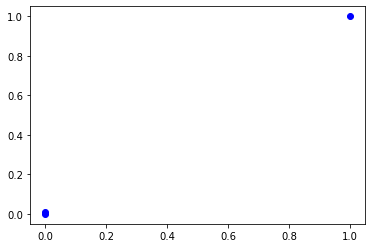

In [21]:
validAcc = metrics.accuracy_score(validLabels, validPreds)
validBalancedAcc = metrics.balanced_accuracy_score(validLabels, validPreds)
validF1Score = metrics.f1_score(validLabels, validPreds)
validPrecision = metrics.precision_score(validLabels, validPreds)
validRecall = metrics.recall_score(validLabels, validPreds)
validAuroc = metrics.roc_auc_score(validLabels, validPreds)

print("on validation data, the naive bayes baseline predictor achieved:\n",
      "accuracy= ", validAcc, "; balanced accuracy = ", validBalancedAcc,
      "\nF1 score= ", validF1Score, "; AUROC score (seems to be based on the broken roc curve plotted below)= ", validAuroc,
      "\nPrecision= ", validPrecision, "; Recall= ", validRecall)

validFprs, validTprs, validRocThresholds = metrics.roc_curve(validLabels, validPreds)
validAuc = metrics.auc(validFprs, validTprs)

plt.plot(validFprs, validTprs, 'bo')


built-in ROC curve plotter:
so the actual AUC for validation data is 0.87


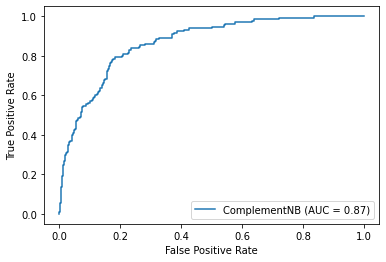

In [22]:
print("built-in ROC curve plotter:")
metrics.plot_roc_curve(naiveBayesPredictor, validDataMatrix, validLabels)
plt.show()
print("so the actual AUC for validation data is 0.87")

In [12]:
#todo run against test set